In [81]:
import geopy
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

In [56]:
!unzip daily_HAPS_2018.zip
!unzip daily_HAPS_2019.zip
!unzip daily_HAPS_2020.zip

unzip:  cannot find or open daily_HAPS_2019.zip, daily_HAPS_2019.zip.zip or daily_HAPS_2019.zip.ZIP.
unzip:  cannot find or open daily_HAPS_2020.zip, daily_HAPS_2020.zip.zip or daily_HAPS_2020.zip.ZIP.
unzip:  cannot find or open daily_HAPS_2021.zip, daily_HAPS_2021.zip.zip or daily_HAPS_2021.zip.ZIP.


In [69]:
df_HAPS_2020 = pd.read_csv('daily_HAPS_2020.csv')
df_HAPS_2019 = pd.read_csv('daily_HAPS_2019.csv')
df_HAPS_2018 = pd.read_csv('daily_HAPS_2018.csv')

In [70]:
HAPS_NYC_2018 = df_HAPS_2018.loc[df_HAPS_2018['City Name'] == 'New York']
HAPS_NYC_2019 = df_HAPS_2019.loc[df_HAPS_2019['City Name'] == 'New York']
HAPS_NYC_2020 = df_HAPS_2020.loc[df_HAPS_2020['City Name'] == 'New York']

In [71]:
HAPS_NYC_2018.head(3)

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
202219,36,5,110,43218,2,40.816,-73.902,WGS84,"1,3-Butadiene",24 HOUR,NaN,2018-01-02,Parts per billion Carbon,None,1,100.0,0.1,0.1,0,NaN,150,SS 6L - PRESSURIZED CANISTER - CRYOGENIC PREC...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2019-03-27
202220,36,5,110,43218,2,40.816,-73.902,WGS84,"1,3-Butadiene",24 HOUR,NaN,2018-01-08,Parts per billion Carbon,None,1,100.0,0.2,0.2,0,NaN,150,SS 6L - PRESSURIZED CANISTER - CRYOGENIC PREC...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2019-03-27
202221,36,5,110,43218,2,40.816,-73.902,WGS84,"1,3-Butadiene",24 HOUR,NaN,2018-01-14,Parts per billion Carbon,None,1,100.0,0.1,0.1,0,NaN,150,SS 6L - PRESSURIZED CANISTER - CRYOGENIC PREC...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2019-03-27


In [72]:
dataframes = [HAPS_NYC_2018,HAPS_NYC_2019,HAPS_NYC_2020]

In [147]:
# value counts for pollutant measures in NYC
HAPS_NYC_2019['Parameter Name'].value_counts()

Acetaldehyde                 574
Formaldehyde                 574
Benzene                      559
1,3-Butadiene                525
Ethylene dichloride          413
Carbon tetrachloride         413
Vinyl chloride               413
Ethylene dibromide           413
1,1,2,2-Tetrachloroethane    413
1,2-Dichloropropane          413
Chloroform                   413
trans-1,3-Dichloropropene    413
Dichloromethane              413
Trichloroethylene            413
Tetrachloroethylene          413
cis-1,3-Dichloropropene      413
Arsenic PM2.5 LC             351
Nickel PM2.5 LC              351
Manganese PM2.5 LC           351
Chromium PM2.5 LC            351
Cadmium PM2.5 LC             351
Lead PM2.5 LC                351
Acrolein - Unverified        172
Name: Parameter Name, dtype: int64

In [109]:
# creating dataframes for the different pollutants in NYC by year
# this is necessary because the pollutant values
HAPS_NYC_LEAD_2018 = HAPS_NYC_2018.loc[HAPS_NYC_2018['Parameter Name'] == 'Lead PM2.5 LC']
HAPS_NYC_LEAD_2019 = HAPS_NYC_2019.loc[HAPS_NYC_2019['Parameter Name'] == 'Lead PM2.5 LC']
HAPS_NYC_LEAD_2020 = HAPS_NYC_2020.loc[HAPS_NYC_2020['Parameter Name'] == 'Lead PM2.5 LC']

In [89]:
# average lead over time
avg_lead_time = [HAPS_NYC_LEAD_2018['Arithmetic Mean'].mean(),HAPS_NYC_LEAD_2019['Arithmetic Mean'].mean(),HAPS_NYC_LEAD_2020['Arithmetic Mean'].mean()]
time = [2018,2019,2020]

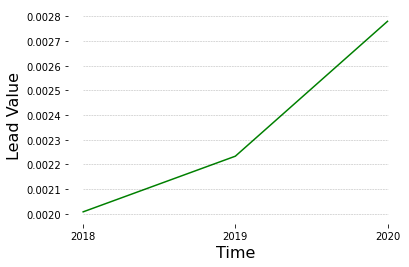

In [132]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(time, avg_lead_time, c='green');

for i in range(9):
    grid_val = i * 0.0001 + 0.0020
    plt.plot([2018, 2020], 
             [grid_val, grid_val],
             '--',
             c='black',
             lw=0.5,
             alpha=0.3);

plt.locator_params(axis='x', nbins=3)
plt.ylabel('Lead Value', fontsize=16)
plt.xlabel('Time', fontsize=16);

plt.savefig('lead_val.png')

In [103]:
percent_increase = (100 * (avg_lead_time[2] - avg_lead_time[0])) / avg_lead_time[0]

print('The amount of lead in the air in NYC has increased', str("{:.2f}".format(percent_increase)) + '%')

The amount of lead in the air in NYC has increased 38.40%


In [116]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application')

In [133]:
# testing how long it will take to get 20 zipcodes
sm_haps = HAPS_NYC_2018.head(20)

import timeit

start = timeit.default_timer()

zipcodes = sm_haps.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

stop = timeit.default_timer()

print('Time: ', stop - start)  


Time:  9.678236343999743


In [148]:
# taking the zipcode function to find the zipcodes for given coordinates
zipcodes = HAPS_NYC_LEAD_2020.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

HAPS_NYC_LEAD_2020['Zipcodes'] = zipcodes

In [149]:
HAPS_NYC_LEAD_2020.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,Zipcodes
128347,36,5,110,88128,5,40.816,-73.902,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-01,Micrograms/cubic meter (LC),None,1,100.0,0.004,0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128348,36,5,110,88128,5,40.816,-73.902,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-04,Micrograms/cubic meter (LC),None,1,100.0,-0.003,-0.003,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128349,36,5,110,88128,5,40.816,-73.902,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-07,Micrograms/cubic meter (LC),None,1,100.0,0.004,0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128350,36,5,110,88128,5,40.816,-73.902,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-10,Micrograms/cubic meter (LC),None,1,100.0,0.006,0.006,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128351,36,5,110,88128,5,40.816,-73.902,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-13,Micrograms/cubic meter (LC),None,1,100.0,-0.004,-0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455


In [184]:
# reading in the income data to merge
income = pd.read_csv('Income.csv')

income = income.astype({"Zip Code": int})
income = income.rename(columns={"Zip Code": "Zipcodes"},inplace=True)

In [185]:
HAPS_NYC_LEAD_2020 = HAPS_NYC_LEAD_2020.astype({"Zipcodes": int})

In [186]:
# merging our HAPS and Income datasets with inner join by 'Zipcode'
FINAL_HAPS_NYC_LEAD_2020 = pd.concat([HAPS_NYC_LEAD_2020, income], axis=1)

FINAL_HAPS_NYC_LEAD_2020

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,Zipcodes
128347,36,5,110,88128,5,40.81600,-73.90200,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-01,Micrograms/cubic meter (LC),None,1,100.0,0.004,0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128348,36,5,110,88128,5,40.81600,-73.90200,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-04,Micrograms/cubic meter (LC),None,1,100.0,-0.003,-0.003,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128349,36,5,110,88128,5,40.81600,-73.90200,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-07,Micrograms/cubic meter (LC),None,1,100.0,0.004,0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128350,36,5,110,88128,5,40.81600,-73.90200,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-10,Micrograms/cubic meter (LC),None,1,100.0,0.006,0.006,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
128351,36,5,110,88128,5,40.81600,-73.90200,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-01-13,Micrograms/cubic meter (LC),None,1,100.0,-0.004,-0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,IS 52,IS 52 681 KELLY ST,New York,Bronx,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,10455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139366,36,81,124,88128,6,40.73614,-73.82153,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-11-17,Micrograms/cubic meter (LC),None,1,100.0,0.004,0.004,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,QUEENS COLLEGE 2,Queens College 65-30 Kissena Blvd Parking L...,New York,Queens,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,11367
139367,36,81,124,88128,6,40.73614,-73.82153,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-11-20,Micrograms/cubic meter (LC),None,1,100.0,0.003,0.003,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,QUEENS COLLEGE 2,Queens College 65-30 Kissena Blvd Parking L...,New York,Queens,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,11367
139368,36,81,124,88128,6,40.73614,-73.82153,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-11-23,Micrograms/cubic meter (LC),None,1,100.0,0.003,0.003,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,QUEENS COLLEGE 2,Queens College 65-30 Kissena Blvd Parking L...,New York,Queens,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,11367
139369,36,81,124,88128,6,40.73614,-73.82153,WGS84,Lead PM2.5 LC,24 HOUR,NaN,2020-11-26,Micrograms/cubic meter (LC),None,1,100.0,-0.006,-0.006,0,NaN,811,Met One SASS/SuperSASS Teflon - Energy Dispers...,QUEENS COLLEGE 2,Queens College 65-30 Kissena Blvd Parking L...,New York,Queens,New York,"New York-Newark-Jersey City, NY-NJ-PA",2021-05-13,11367


In [187]:
# confirming that our concatenation worked
FINAL_HAPS_NYC_LEAD_2020.isnull().sum()

State Code               0
County Code              0
Site Num                 0
Parameter Code           0
POC                      0
Latitude                 0
Longitude                0
Datum                    0
Parameter Name           0
Sample Duration          0
Pollutant Standard     186
Date Local               0
Units of Measure         0
Event Type               0
Observation Count        0
Observation Percent      0
Arithmetic Mean          0
1st Max Value            0
1st Max Hour             0
AQI                    186
Method Code              0
Method Name              0
Local Site Name          0
Address                  0
State Name               0
County Name              0
City Name                0
CBSA Name                0
Date of Last Change      0
Zipcodes                 0
dtype: int64